# Прогнозирование вероятности дефолта заемщика

### Импорт необходимых библиотек

In [777]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from pandas import Series
import warnings
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from catboost.utils import create_cd
from catboost import CatBoostClassifier, Pool

RANDOM_SEED = 42

### Импорт данных 

In [778]:
data_directory = 'sf-dst-scoring/'#'/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(data_directory+'train.csv')
df_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

 #### Описания полей датасета

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту


In [779]:
# для одновременной обработки всех признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест
data = pd.concat([df_train, df_test], ignore_index=True, sort=False)

### Проведем анализ данных

In [780]:
df_train.shape, df_test.shape##, data.shape

((73799, 20), (36349, 19))

In [781]:
display(data.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [782]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [783]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
default             73799 non-null float64
Train               110148 non-null int64
dtypes: float64(2), int64(12), object(6)

#### Идентификатор клиента никак не влияет на выбор решения. удаляем

In [784]:
data = data.drop(['client_id'], axis=1)

#### Посмотрим на заполняемость признаков

In [785]:
data.isnull().sum()

app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

#### Признак education пропущен в 478 записях. Это незначительное кол-во по сравнению с общим кол-вом записей. Но удалять не будет, заполним самым популярным

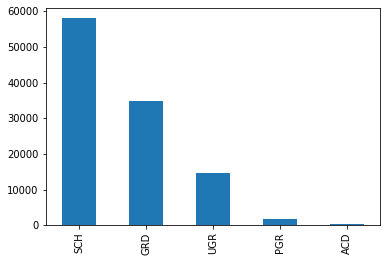

In [786]:
data['education'].value_counts().plot.bar()

In [787]:
# Заполняем SCH
data['education'] = data['education'].fillna('SCH')

In [788]:
data.isnull().sum()

app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

#### Посмотрим на признаки типа object, поймем как их можно преобразовать в числовые

In [789]:
data.describe(include = 'object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,110148,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,58476,61836,74290,89140,93721


#### Все эти признаки, за исключением app_date, категориальные. Посмотрим как ведет себя модель без категориальных признаков. Удалим их, обучим случайный лес (пока  без гиперпараметров) и посмотрим  ROC_AUC на кросс-валидации и на отложенной выборке. Это будет наш baseline

In [790]:
# !!! временно удадлим все train=1 для того чтобы избавиться от y=nan !!!
data_no_obj = data.query('Train == 1').drop(['Train'], axis=1)
# выносим object
data_no_obj, y = data_no_obj.loc[:, data.dtypes != 'object'].drop('default', axis=1), data_no_obj['default']

In [791]:
# сплитуем датафрейм
data_no_obj_train, data_no_obj_test, y_train, y_test = \
    train_test_split(data_no_obj, y, test_size=0.3, random_state = RANDOM_SEED)

In [792]:
# обучаем модель случайным лесом
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [793]:
# смотрим roc_auc обученной модели на тестовых данных 
forest.fit(data_no_obj_train, y_train)
roc_auc_score(y_test, forest.predict_proba(data_no_obj_test)[:,1])

0.6822029029668827

### Показатель roc_auc низкий, 0.683. Поработаем с признаками

#### Модель будем строить используя методы градиентного бустинга, который  работает с числовыми признаками. Если  присутствуют не только числовые, но и категориальные признаки, то  преобразуем их в числовые. 
#### Сперва разберемся с признаками типа object и посмотрим как их преобразовать в числовые значения

In [794]:
# изучаем уникальные значения признаков
for column in data.columns[data.dtypes == 'object' ]:
    print('Уникальные значения в полях типа object {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в полях типа object app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'


In [795]:
# До преобразования добавим новый признак scorbal, орпеделяющий из логики андеррайтера наиболее предсказуемого 
# с т.з. кредитования клиента. Обычно самый привлекательный для банка клиент – это предсказуемый клиент. 

data['scorbal'] = (
    np.select(
        condlist=[(data['age'] >= 25) & (data['age'] <= 55) & (data['car']=="Y") & (data['foreign_passport'] == "Y"),
                  (data['region_rating']<60) & (data['good_work']==0) & (data['bki_request_cnt']>3)], 
        choicelist=[1, 0], 
        default=0.5)
                  )    

#### Теперь преобразуем категориальные признаки в числовые с использованием LabelEncoder

In [796]:
bin_columns = ['education', 'sex', 'car', 'car_type', 'foreign_passport', 'scorbal']

# Преобразуем бинальные признаки
label_encoder = LabelEncoder()
for col in bin_columns:
    data[col] = label_encoder.fit_transform(data[col])
    
# убедимся в преобразовании    
data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,scorbal
0,01FEB2014,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,1
1,12MAR2014,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,1
2,01FEB2014,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,2
3,23JAN2014,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,1
4,18APR2014,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,1


In [797]:
#посмотрим повнимательней на категориальные признаки
for column in data.columns:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'
 '10FEB2014' 

In [798]:
# Преобразуем формат признака app_date
data.app_date = pd.to_datetime(data.app_date)
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

# И посмотрим на диапазон дат
print('дата начала: {:%d, %b %y} - дата окончания: {:%d, %b %y}'.format(data.app_date.min(), data.app_date.max()))

дата начала: 01, Jan 14 - дата окончания: 30, Apr 14


In [799]:
# Введем еще один новый признак - кол-во дней с 1 января до даты app_date
start = data.app_date.min()
data['app_days'] = (data.app_date - start).dt.days.astype('int')

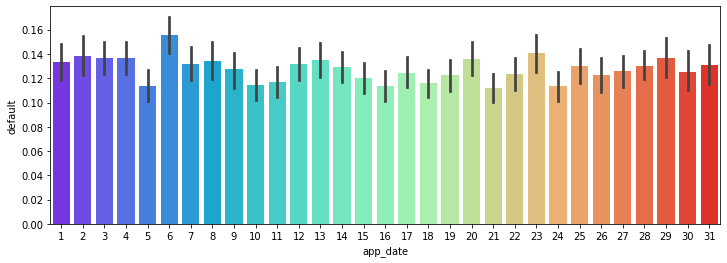

In [800]:
# посмотрим на распределение дней.
plt.subplots(figsize=(12, 4))
sns.barplot(data=data[data['Train']==1], 
            x=data.loc[data['Train']==1,'app_date'].dt.day, 
            y='default', 
            palette="rainbow")

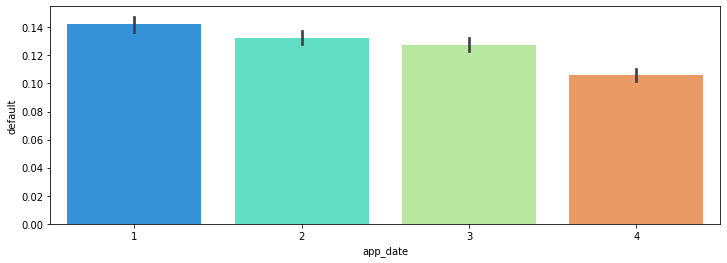

In [801]:
# Признак  равномерно распределен внутри месяца. посмотрим на распределение по месяцам
plt.subplots(figsize=(12, 4))
sns.barplot(data=data[data['Train']==1], 
            x=data.loc[data['Train']==1,'app_date'].dt.month, 
            y='default',
            palette="rainbow")

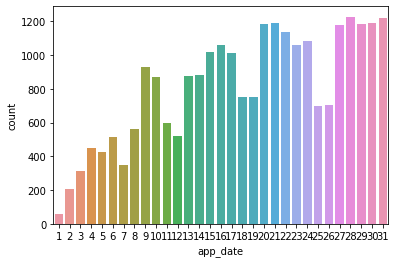

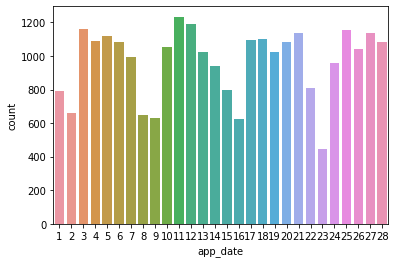

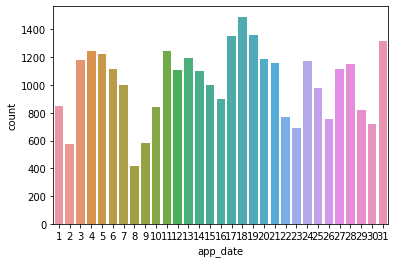

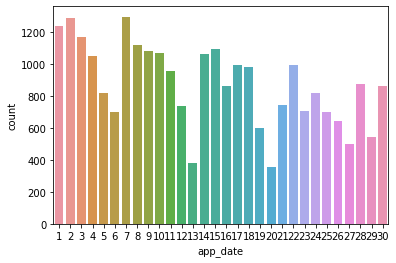

In [802]:
# попробуем добавить признак месяц подачи заявки 
data['month'] = data['app_date'].dt.month
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=data[data.month == i]['app_date'].dt.day, data=data[data.month == i])
    plt.show()

In [803]:
# Посмотрим на еще один признак num_of_app_date, определяющий количество заявок по дням

num_of_app_date = data['app_date'][(data['default'] == 0)].value_counts()
num_of_app_date

2014-03-18    897
2014-03-19    793
2014-03-31    791
2014-03-17    782
2014-04-07    772
             ... 
2014-04-20    218
2014-01-07    183
2014-01-03    169
2014-01-02    119
2014-01-01     37
Name: app_date, Length: 120, dtype: int64

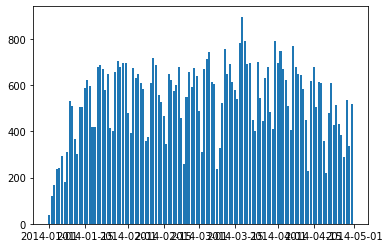

In [804]:
# Посмотрим на распределение количествава заявок по дням. Аналогично посмотрим на других признаках

plt.bar(num_of_app_date.index, num_of_app_date)
plt.show()

In [805]:
# Распределение нормальное. Добавим новый признак num_of_app в датасет
data['num_of_app'] = data['app_date'].replace(to_replace=num_of_app_date.to_dict())

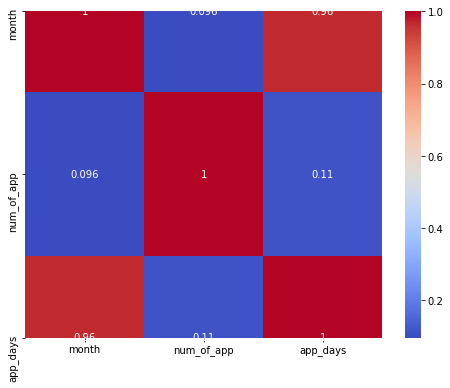

In [806]:
# Посмотрим как 3 признака кореллируют друг с другом 
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,['month', 'num_of_app', 'app_days']].corr(),annot = True, cmap = 'coolwarm')

In [807]:
#Признаки month и app_days сильно коррелируют между собой. удаляем один из них - month
data = data.drop(['month'], axis=1)

In [808]:
# И удаляем признак app_date, он более не нужен
data = data.drop(['app_date'], axis=1)

In [809]:
# ИТОГО 
for column in data.columns:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле education : [3 1 4 2 0]
Уникальные значения в поле sex : [1 0]
Уникальные значения в поле age : [62 59 25 53 48 27 39 50 54 29 32 30 23 37 36 41 28 58 26 45 44 43 56 40
 34 33 67 38 46 42 35 24 61 21 52 55 49 57 31 64 63 51 22 65 47 66 68 60
 69 70 72 71]
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Уникальные значения в поле decline_app_cnt : [ 0  2  1  3  4  6  5  7  8  9 13 11 19 10 22 33 14 12 15 24 16 21 30 20]
Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле score_bki : [-2.00875292 -1.53227621 -1.40814226 ... -0.94075193 -1.24239173
 -1.50754938]
Уникальные значения в поле bki_request_cnt : [ 1  3  2  0  4  7  5  8  6 13 10 22 12 11 34  9 16 14 26 21 18 24 15 19
 32 17 20 23 27 36 53 25 45 33 28 41 29 46 47 40]
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Уникальные значени

### Посмотрим еще раз на ROC_AUC после очистки данных и добавления признаков

In [810]:
# !!! временно удадлим все train=1 для того чтобы избавиться от y=nan !!!
data_no_obj = data.query('Train == 1').drop(['Train'], axis=1)
# выносим object
data_no_obj, y = data_no_obj.loc[:, data.dtypes != 'object'].drop('default', axis=1), data_no_obj['default']

In [811]:
# сплитуем датафрейм
data_no_obj_train, data_no_obj_test, y_train, y_test = \
    train_test_split(data_no_obj, y, test_size=0.3, random_state = RANDOM_SEED)

In [812]:
# задаём параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for train_index, test_index in skf.split(data_no_obj_train, y_train):
    print("TRAIN_index:", train_index, "TEST_index:", test_index)   

TRAIN_index: [    1     2     3 ... 51655 51656 51658] TEST_index: [    0    12    14 ... 51646 51653 51657]
TRAIN_index: [    0     2     3 ... 51655 51656 51657] TEST_index: [    1     6    18 ... 51652 51654 51658]
TRAIN_index: [    0     1     2 ... 51656 51657 51658] TEST_index: [    4    16    20 ... 51633 51638 51650]
TRAIN_index: [    0     1     2 ... 51656 51657 51658] TEST_index: [    7    10    11 ... 51627 51635 51637]
TRAIN_index: [    0     1     4 ... 51654 51657 51658] TEST_index: [    2     3     5 ... 51651 51655 51656]


In [813]:
# обучаем модель случайным лесом
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [814]:
# смотрим на значание roc_auc на кроссвалиадции
np.mean(cross_val_score(forest, data_no_obj_train, y_train, 
                       cv=skf, scoring='roc_auc'))

0.7067161263801668

In [815]:
# смотрим roc_auc обученной модели на тестовых данных 
forest.fit(data_no_obj_train, y_train)
roc_auc_score(y_test, forest.predict_proba(data_no_obj_test)[:,1])

0.7066094242374695

#### roc_auc чуть улучшился. продожим улучшать качество данных

#### Разобъем переменные по 3м группам

In [816]:
# внесем данные из резюме в списки 
# бинарные переменные (default не включаем в список)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'scorbal']
# числовые переменные, client_id исключили из списка (8)
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'app_days', 'num_of_app']

### Анализ по группам переменных¶


#### Числовые признаки

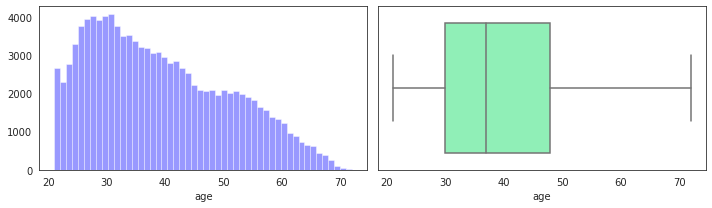

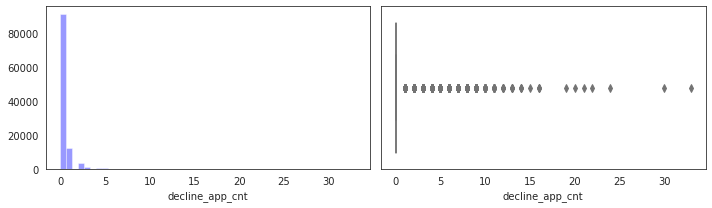

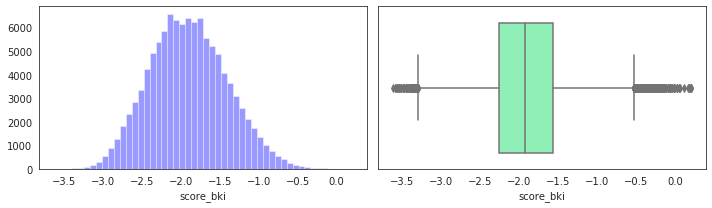

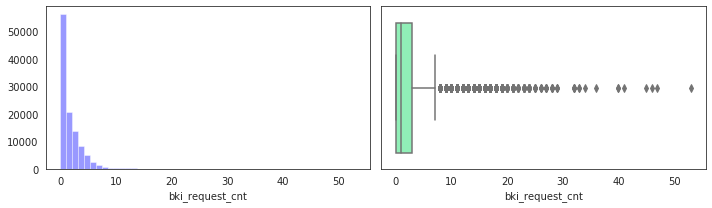

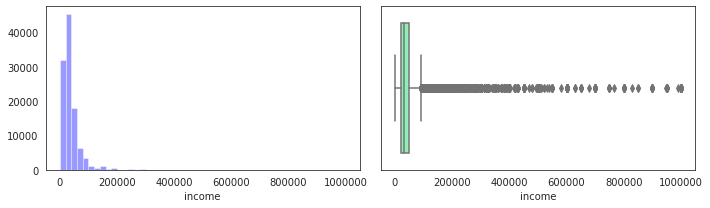

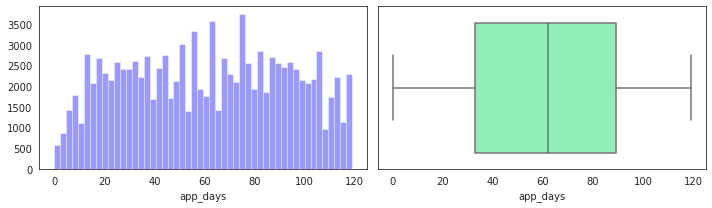

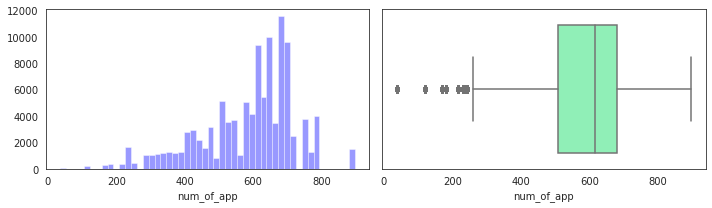

In [817]:
# Построим графики распределения заемщиков по признакам
# работаем по циклу с переменными 
# рассматриваем для строк из тренирововчного датасета

for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(data[i], kde = False, rug=False, color='b')

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data[i], palette='rainbow')

    f.tight_layout()
    

#### У всех признаков в большей или меньшей степени наблюдаются выбросы
#### У признаков, кроме 'score_bki' и 'days' и 2х новых, нет нормального распределения
#### Пробуем логарифмировать признаки и смотрим на результат

In [818]:
# сделаем логарифмирование через копию data
data_log = data.copy(deep=True)

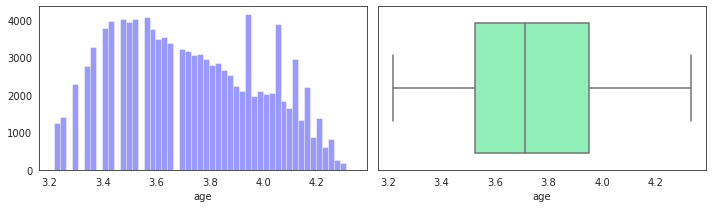

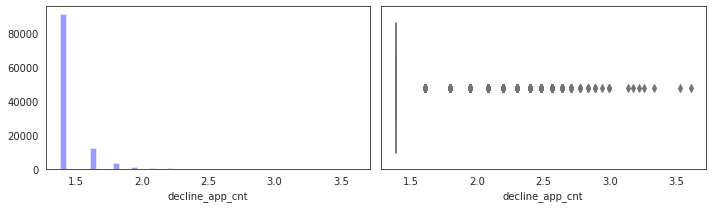

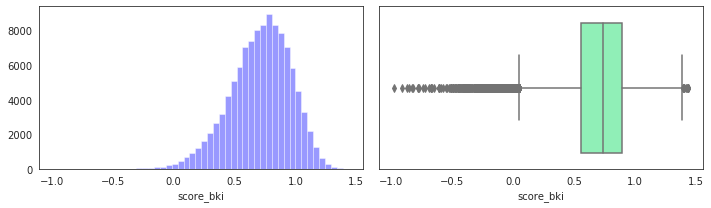

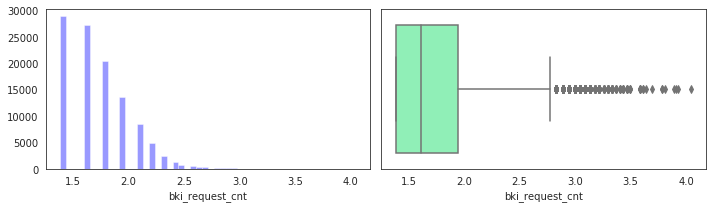

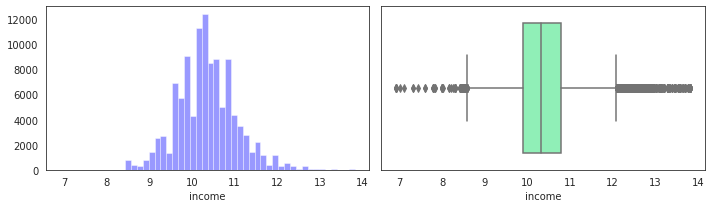

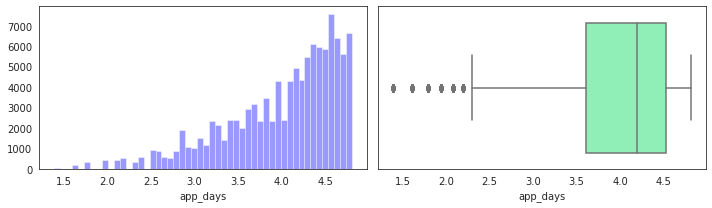

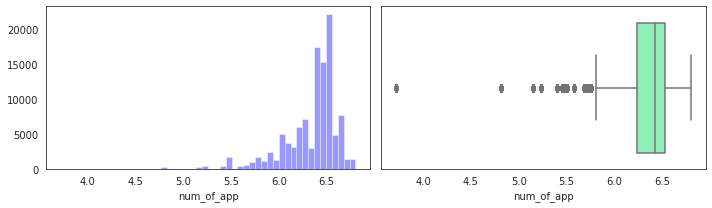

In [819]:
for i in num_cols:
    data_log[i] = np.log(data_log[i] + 4)
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(data_log[i], kde = False, rug=False, color='b')

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data_log[i], palette='rainbow')

    f.tight_layout()

In [820]:
#age - распределение стало нормальным, оставляем логарифмированное значение
data.age = data_log.age

In [821]:
# decline_app_cnt - распределение нормальное, очень сильно смещенное и после логарифмирования 
# Выбросов очень много даже после логарифмирования.
# посмотрим внимательней на распределелние по значению прознака.
data.decline_app_cnt.value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

In [822]:
# видим, что более 83% - это значение 0. То есть ранее в большинстве случаев  отказов не было. 
# Перенесем этот признак в разряд категориальных, проведя агрегацию:
#0 : 0; 1-2 : 1; 3 и более : 2
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: 2 if x >=3 else (1 if x>0 else 0))
cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

In [823]:
# score_bki - после логарифмирования распределение сместилось вправо и выбросов стало больше. 
# Поэтому не будет логарифмировать признак.

# bki_request_cnt - распределение сильно лучше не стало, но сократилось количество выбросов. 
# Оставляем логарифмированные данные

data['bki_request_cnt'] = data_log['bki_request_cnt']

In [824]:
# income - После логарифмирования распределение стало более нормальным и значительно сократилось количество выбросов. 
# оставляем логарифм
# Остальные пока оставим в первоначальном виде
data['income'] = data_log['income']

#### Выполним «центровку» и «стандартизацию» данных путём их масштабирования. 
#### Масштабирование выполняется из-за того, что разные величины выражены в разных единицах измерения. 
#### Эта процедура позволяет организовать «честную схватку» между признаками при определении их важности.

In [825]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

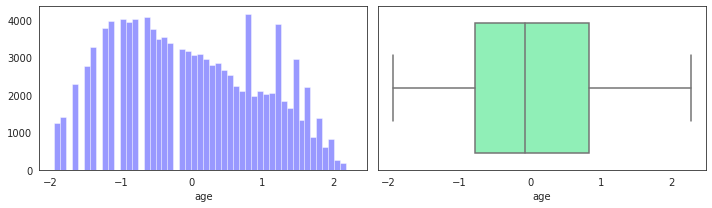

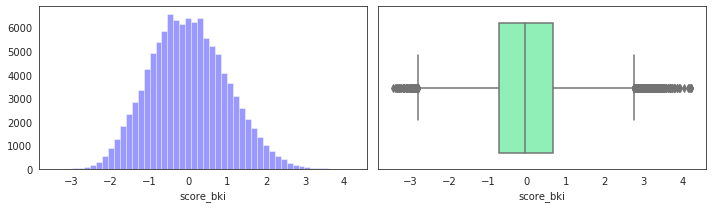

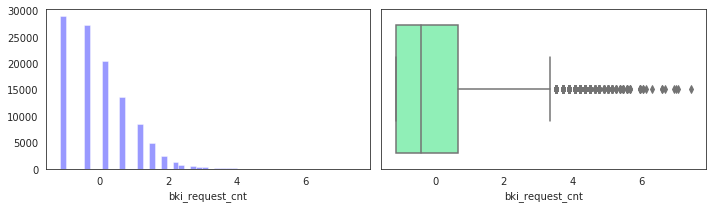

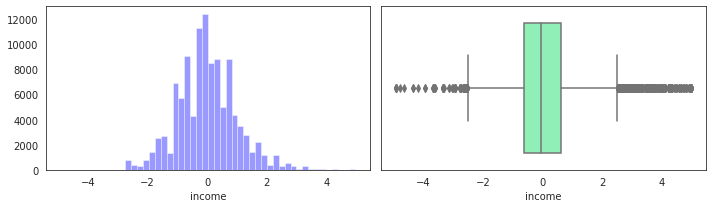

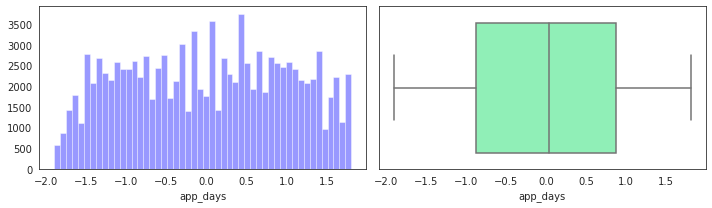

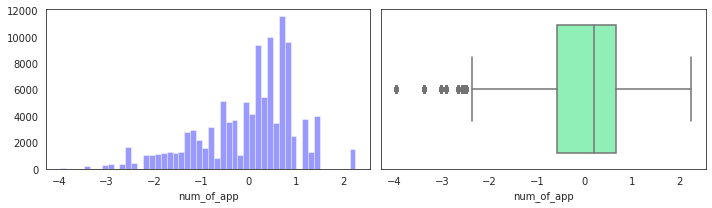

In [826]:
# смотрим, что получилось: 
for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(data[i], kde = False, rug=False, color='b')

    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data[i], palette='rainbow')

    f.tight_layout()
    

#### От выбросов избавиться не удалось, но их количество существенно уменьшилось и распределение всех числовых признаков нормальное. Выбросы удалять не будем

### Категориальные признаки¶


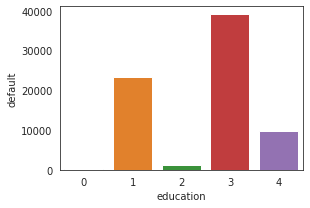

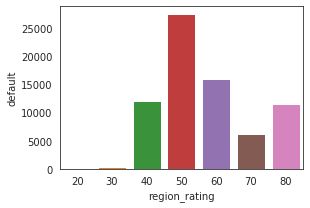

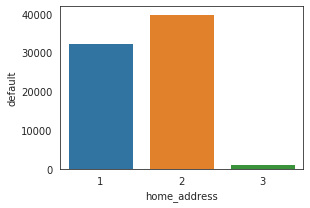

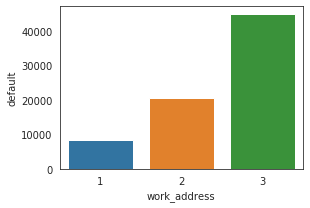

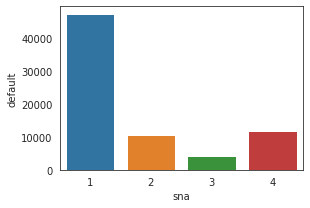

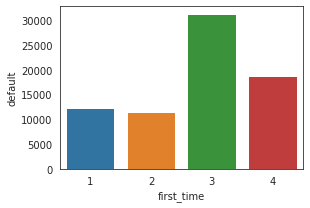

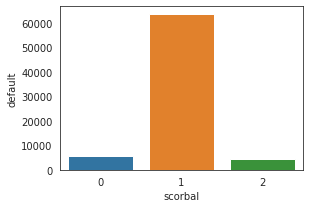

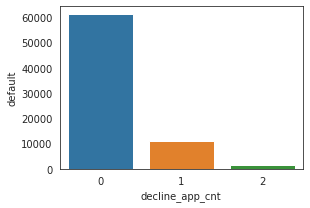

In [827]:
# визуализация категориальных признаков
for i in cat_cols:
    f = plt.figure(figsize=(15, 3))
    gs = f.add_gridspec(1, 4)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.barplot(x=i, y='default', data=data[data['Train'] ==1], estimator=len)
    f.tight_layout()

In [828]:
# Закодируем region_rating
label_encoder = LabelEncoder()
data['region_rating'] = label_encoder.fit_transform(data['region_rating'])
data.region_rating.unique()

array([3, 6, 4, 2, 5, 0, 1], dtype=int64)

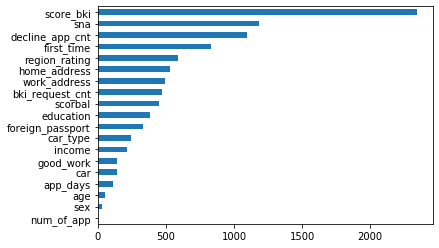

In [829]:
# посмотрим значимость признаков
imp_num = Series(f_classif(data[data['Train']==1][num_cols+cat_cols+bin_cols], data[data['Train']==1]['default'])[0], index = num_cols+cat_cols+bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Тут планировал все категориальные признаки на dummies поменять, но не буду. предсказания от этого в нашем случае не улучшаются

### Бинарные признаки

In [830]:
# проверим еще раз на уникальность 
for column in bin_cols:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле sex : [1 0]
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле foreign_passport : [0 1]


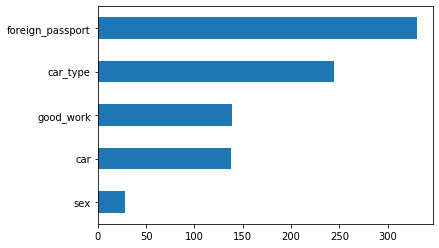

In [831]:
# посмотрим значимость признаков

imp_num = Series(f_classif(data[data['Train']==1][bin_cols], data[data['Train']==1]['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Посмотрим корреляцию 

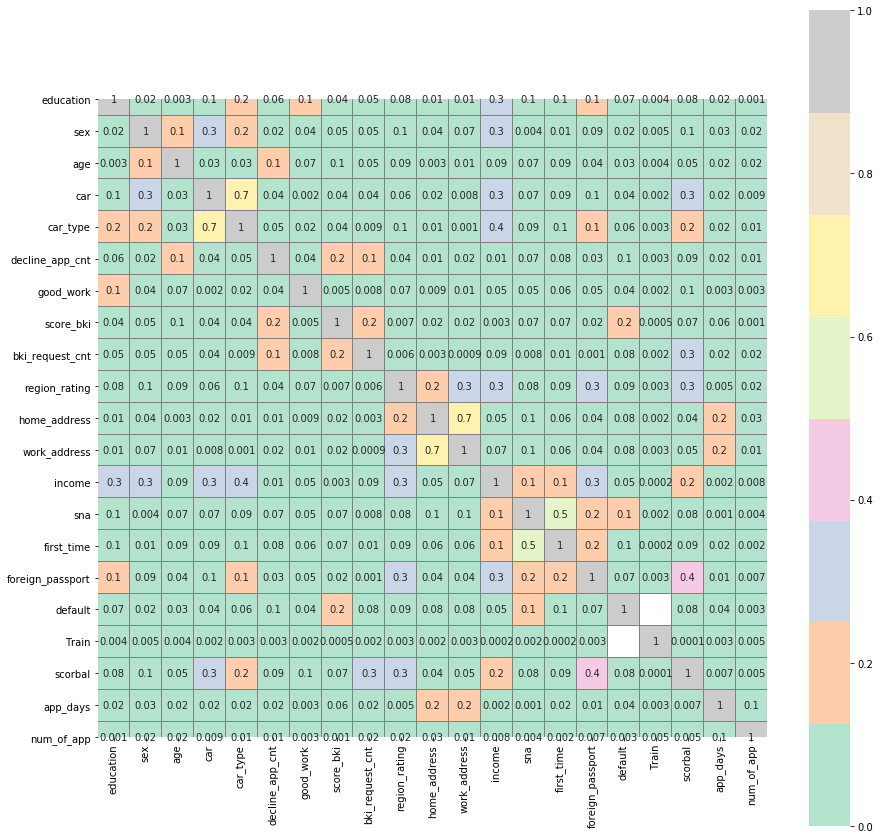

In [832]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr().abs(),
            vmin=0, vmax=1, annot=True, fmt = '.1g', cmap='Pastel2', linewidths=0.01, linecolor='grey',square=True)

#### Наблюдается высокая корреляция между car и car_type, home_address и work_address с высокой значимостью. Удалять не будем 

In [833]:
#data = data.drop(['car'], axis=1)
#data = data.drop(['work_address'], axis=1)
#data = data.drop(['scorbal'], axis=1)

### Переходим к построению модели

In [834]:
# готовим датасеты и целевые переменные
train_data = data.query('Train == 1').drop(['Train'], axis=1)
test_data = data.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

In [835]:
# сплитуем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, X_train.shape, X_test.shape)

(73799, 19) (59039, 19) (14760, 19)


In [836]:
# Начнем с логистической регрессии
warnings.simplefilter('ignore')
model = LogisticRegression(max_iter = 2000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [837]:
#Определим класс для функций вывода метрик и построения confusion_matrix

class ModelInspect(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)
        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Pastel1', cbar = False, \
                 #xticklabels = ['Дефолт','Не дефолт'], 
                    yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        plt.figure()
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)
        plt.show()


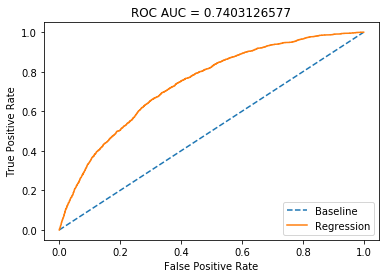

accuracy     0.875000
precision    0.406250
recall       0.021346
F1           0.040562
ROC_AUC      0.740313
dtype: float64

In [838]:
#Построим ROC-кривую и посчитаем метрики для логистической регрессии¶
mi_1 = ModelInspect(model, X_test, y_test)
mi_1.roc_curve_plot()
mi_1.get_metrics()

#### Метрика ROC_AUC - достаточно велика (0.740313), что указывает на удовлетворительный уровень предсказывания целевого показателя. Но нужно еще попробовать поработать с настройками.

#### Не смотря на то, что значения ROC_AUC и метрика правильности accuracy достаточно высоки, значения параметра  recall  указывает на низкий уровень "угадывания" хороших заемщиков, из-за чего Банк может недополучить объем прибыли. 

#### Посмотрим на матрицу ошибок:

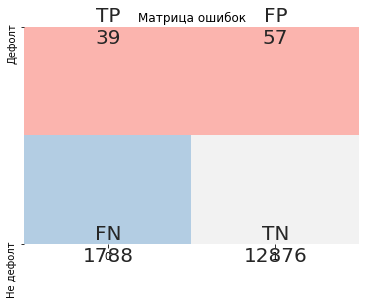

In [839]:
mi_1.confusion_matrix_plot()

#### Видим, почему показатель accuracy высокий. Модель разбалансированна, очевиден перекос в торону зоны  "не дефолтных" ответов. Нашей модели  "удобней" сказать "нет". Видим также высокий уровень ошибки второго рода (ложно отрицательных ответов). Как следствие показатель  F1 низкий, что также указывет  на низкую предсказательность модели. 

#### Попробуем: а) сбалансировать модель; б) применить регуляризацию.

### Сбалансированность default¶


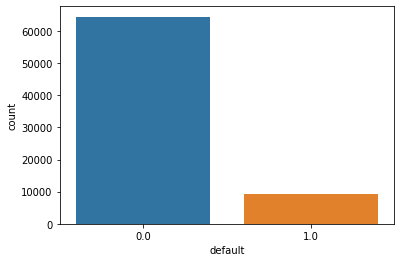

In [840]:
ax = sns.countplot(x="default", data=data)

#### Выборка разбалансирована. Для сглаживания влияния несбалансированности применим параметр модели

#### class_weight = 'balanced' - параметр для балансировки классов

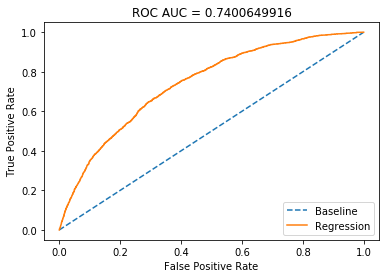

In [841]:
model = LogisticRegression(class_weight='balanced', max_iter = 2000, random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_balanced = ModelInspect(model, X_test, y_test)
mi_balanced.roc_curve_plot()

In [842]:
mi_balanced.get_metrics()

accuracy     0.669241
precision    0.225121
recall       0.684729
F1           0.338841
ROC_AUC      0.740065
dtype: float64

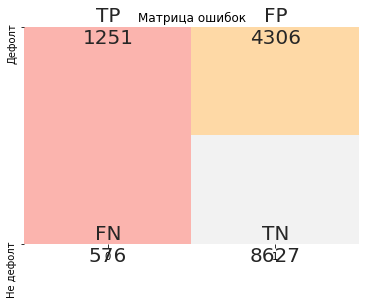

In [843]:
mi_balanced.confusion_matrix_plot()

### ROC_AUC = 0.740065
#### Ошибка второго рода значительно уменьшилась, также улучшились метрики recall и f1, это означает, что предсказание модели улучшилось. Однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует получить убыток связанный с невозможностью клиентов обслуживать свои долги. Нужно прововать найти золотую середину.

#### Попробуем выполнить undersampling - уменьшение кол-ва объектов класса-большинства и  улучшение балансировки default

In [844]:
from imblearn.under_sampling import RandomUnderSampler

In [845]:
train_data = data.query('Train == 1').drop(['Train'], axis=1)
test_data = data.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

In [846]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

In [847]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

9372 9372


#### Мы видим, что теперь оба класса default = {0,1} распределены равномерно. Именно на этой выборке обучим модель.

In [848]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=RANDOM_SEED)

In [849]:
model_us = LogisticRegressionCV(
  Cs = np.logspace(-4, 4, 100),
  cv = 4,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 500,   
  n_jobs = -1,
  random_state = RANDOM_SEED,
)

model_us.fit(X_train, y_train)
mi_us = ModelInspect(model_us, X_test, y_test)

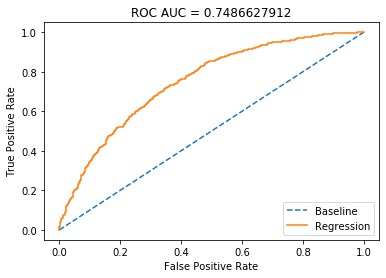

In [850]:
mi_CV = ModelInspect(model, X_test, y_test)
mi_CV.roc_curve_plot()

### ROC_AUC = 0.744339

In [851]:
mi_CV.get_metrics()

accuracy     0.683733
precision    0.686397
recall       0.694328
F1           0.690339
ROC_AUC      0.748663
dtype: float64

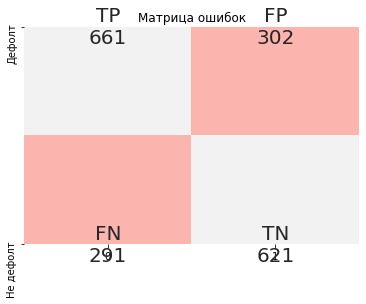

In [852]:
mi_CV.confusion_matrix_plot()

#### На undersampling датасете значения метрик значительнго улучшились. Сбалансированность признаков существенно влияет на качество модели.

# ROC_AUC = 0.748663

### Поиск оптимальных параметров модели¶


In [853]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_max = 100

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(class_weight='balanced', penalty='none', random_state=42,
                   solver='newton-cg')


In [854]:
# Обучим модель на данных и проверим confusion_matrix

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [855]:
#метрики 
mi_opt = ModelInspect(model, X_test, y_test)
mi_opt.get_metrics()


accuracy     0.674667
precision    0.678497
recall       0.682773
F1           0.680628
ROC_AUC      0.747909
dtype: float64

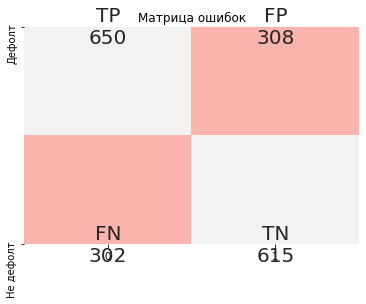

In [856]:
mi_opt.confusion_matrix_plot()

#### Все метрики найденной модели показали хуже результаты, чем наша исходная модель. Останавливаемся на лучшей модели

### Попробуем воспользоваться одним из самых простых алгоритмов классификации - алгоритм k Ближайших Соседей

In [857]:
#код работает около 30 мин

knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)} # возьмем до 25 соседей
knn_gscv = GridSearchCV(knn2, param_grid, cv=5) # и 5 разрезов кросс-валидации

knn_gscv.fit(X_train, y_train)

# посмотрим на лучшую модель и парамтеры
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

{'n_neighbors': 24}
0.6495345108677982


In [858]:
#метрики 
mi_knn_gscv = ModelInspect(knn_gscv, X_test, y_test)

#### Посмотрим на метрики нашей модели

In [859]:
mi_knn_gscv.get_metrics()

accuracy     0.653333
precision    0.666667
recall       0.634454
F1           0.650161
ROC_AUC      0.710811
dtype: float64

#### Результаты оказались чуть хуже


### Финально посмотрим еще на одну модель с использованием метода классификации catboost

In [860]:
# Готовим тренировочные данные
data_cbc = data.query('Train == 1').drop(['Train'], axis=1)
data_cbc, y = data_cbc.drop('default', axis=1), data_cbc['default']
train_data = data.query('Train == 1').drop(['Train'], axis=1)
test_data = data.query('Train == 0').drop(['Train'], axis=1)
y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

In [861]:
#соберем все категориальные/бинальные признаки для построения модели
cat_cols_cbc = []
for c_idx in range(0, data_cbc.columns.shape[0]):
    if data_cbc[data_cbc.columns[c_idx]].unique().max() == 1:
         cat_cols_cbc.append(c_idx)

In [862]:
feature_names = dict()
for column, name in enumerate(data_cbc):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
create_cd(
        label=0,
        cat_features=list(range(1, data_cbc.columns.shape[0])),
        feature_names=feature_names
        )

In [863]:
pool_cbc = Pool(data=data_cbc, label=y, cat_features=cat_cols_cbc)

In [864]:
data_cbc_train, data_cbc_test, y_train, y_test = \
    train_test_split(data_cbc, y, test_size=0.3, random_state = RANDOM_SEED)

In [865]:
# зададим модель
cbc = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    early_stopping_rounds = 20, # для остановки overfitting
    random_state=RANDOM_SEED,
    custom_loss=['AUC','Accuracy'],
    loss_function='Logloss',
    use_best_model=True
)

cbc.fit(
    data_cbc_train, y_train, 
    cat_features = cat_cols_cbc,
    verbose=False, 
    eval_set=(data_cbc_test,y_test),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [866]:
# Посмотрим на параметры
cbc.get_params()

{'iterations': 2000,
 'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'use_best_model': True,
 'custom_loss': ['AUC', 'Accuracy'],
 'random_state': 42,
 'early_stopping_rounds': 20}

#### далее опробовал различные комбинации гиперпараметров. И пока зафиксировал лучшую модель при параметрах ниже с roc_auc=0.742867. Не сдаемся.


In [867]:
mi_cbc = ModelInspect(cbc, data_cbc_test, y_test)

In [868]:
mi_cbc.get_metrics()

accuracy     0.873939
precision    0.443299
recall       0.015468
F1           0.029892
ROC_AUC      0.742867
dtype: float64

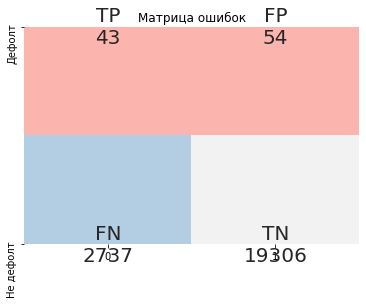

In [869]:
mi_cbc.confusion_matrix_plot()

#### Посмотрим как себя поведет модель на кросс-валидации 

In [870]:
# Посмотрим как себя ведет модель на 5ти фолдах (fold_count = 5). 
# Датасет будем каждый раз перемешивать перед разбиением (shuffle=True)

from catboost import cv
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 300     
params['custom_loss'] = 'AUC'
params['random_state'] = RANDOM_SEED
params['learning_rate'] = 0.04
params['use_best_model'] = True 

cv_data = cv(
    params=params,
    pool=pool_cbc,
    fold_count=5, 
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [871]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.661935,0.000184,0.661893,0.000148,0.657303,0.005783
1,1,0.633094,0.000552,0.633009,0.000307,0.683959,0.009474
2,2,0.606501,0.001351,0.606366,0.000919,0.698692,0.003696
3,3,0.582940,0.001688,0.582785,0.001147,0.704926,0.005691
4,4,0.562772,0.001135,0.562581,0.000664,0.709097,0.007626


In [872]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best Logloss score: {:.4f} i:{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter
     )
     )


Best Logloss score: 0.3388 i:0.0029 on step 293


In [873]:
# попробуем сделать соотношение классов более сбалансированными, и выравним значения нулей и единиц по каждому признаку
# в каждом из фолдов, используя параметр stratified. Установим его в True

from catboost import cv
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 300     
params['custom_loss'] = 'AUC'
params['random_state'] = RANDOM_SEED
params['learning_rate'] = 0.05
params['use_best_model'] = True 

cv_data = cv(
    params=params,
    pool=pool_cbc,
    fold_count=5, 
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])


print('Best Logloss score: {:.4f} i:{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter
     )
     )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best Logloss score: 0.3388 i:0.0013 on step 235


In [874]:
# модель дала чуть лучшие результаты, 
# также можно также заметить что резко уменьшилось стандартное отклонение на сбалансированной выборке

In [875]:
#cv_data
cv_data['test-AUC-mean'][best_iter]

0.7392448305363314

In [876]:
# тут нужно провести анализ показателей выше

In [877]:
# поиграем с дополнительными параметрами, и попробуем вывести  зададим модель
cbc_tunned_model = CatBoostClassifier(
    random_seed=RANDOM_SEED,
    iterations=300,
    learning_rate=0.04,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1, # добавим случайности при выборе score, повысим качество-понизим переобучаемость
    early_stopping_rounds=20, # для остановки overfitting
    one_hot_max_size=10,
    leaf_estimation_method='Newton',
    custom_loss=['AUC','Accuracy'],
    loss_function='Logloss',
    border_count=18,
    thread_count=6,
    use_best_model=True
)

#{'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4}

cbc_tunned_model.fit(
    data_cbc_train, y_train, 
    cat_features = cat_cols_cbc,
    verbose=False, 
    eval_set=(data_cbc_test,y_test),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [878]:
# построим метрики 
m_cbc = ModelInspect(cbc_tunned_model, data_cbc_test, y_test)
m_cbc.get_metrics()

accuracy     0.873893
precision    0.440000
recall       0.015827
F1           0.030556
ROC_AUC      0.742768
dtype: float64

# Финальное значение на сutboost ROC_AUC 0.742768
# Лучшее решение остается ROC_AUC = 0.748663


# Submission

In [879]:
X_test = test_data.drop(['default'], axis=1)

In [880]:
y_pred_prob = model_us.predict_proba(X_test)[:,1]

In [881]:
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob


In [882]:
submit.to_csv('submission_us.csv', index=False)
submit

,client_id,default
0,74835,0.228021
1,17527,0.758293
2,75683,0.357653
3,26883,0.401249
4,28862,0.156240
...,...,...
36344,83775,0.776206
36345,106254,0.121792
36346,81852,0.734461
36347,1971,0.666624
